![banner](img/cdips_2017_logo.png)

## Introduction

This notebook serves as an introduction to the soil properties dataset
and presents the top-line results for all of our models.

Links to the other notebooks in this repo are included throughout.

We'd like to thank the
[Africa Soil Information Service](http://africasoils.net/)
for collecting and cleaning the data,
[Kaggle](kaggle.com/c/afsis-soil-properties)
for hosting the data,
and the
[UC Berkeley Career Development Initiative in the Physical Sciences](CDIPS.physics.berkeley.edu)
for running the
[Data Science Workshop](CDIPS.physics.berkeley.edu/2017-cdips-data-science-workshop/)
for which these materials were originally prepared.

## Software Tools

To make this repo broadly relevant,
we used a technology stack that is,
as of Summer 2017,
representative of the stacks used for data science
in Python.

A brief description of the tools appears below,
along with links to educational materials.
For a general overview of tools used to perform
data science in Python,
check out
[this GitHub repo](https://github.com/donnemartin/data-science-ipython-notebooks).

#### pandas
[pandas](http://pandas.pydata.org/)
is a data management and analysis library that provides easy-to-use, performant data tables. Brandon Rhodes'
[2015 PyCon tutorial](https://github.com/brandon-rhodes/pycon-pandas-tutorial)
is a great, principled introduction to pandas "from the ground up".

#### numpy
[numpy](http://www.numpy.org/)
is a highly performant array-manipulation library.
Justin Johnson's
[tutorial](http://cs231n.github.io/python-numpy-tutorial/)
is an excellent resource for folks with a moderate amount of
prior programming experience,
while the
[numpy for MATLAB users](https://docs.scipy.org/doc/numpy-dev/user/numpy-for-matlab-users.html)
page of the numpy documentation is useful for folks
coming from that language.

#### scikit-learn
[scikit-learn](http://scikit-learn.org/stable/)
is a machine learning and data analysis library
that implements most popular models and various forms
of cross-validation and data pipelining.
[The documentation](http://scikit-learn.org/stable/documentation.html)
is excellent and includes a number of great tutorials
on data science methods.
scikit-learn works well with both pandas and numpy.

#### matplotlib + seaborn
[matplotlib](http://matplotlib.org/)
is a highly flexible plotting library
based on MATLAB's plotting functionality.
In part because of its flexibility,
it can be somewhat tough to get used to.
[seaborn](seaborn.pydata.org)
is a more specialized plotting library
for statistical data visualization
built on top of matplotlib,
and has
[excellent documentation](http://seaborn.pydata.org/tutorial.html).

#### Jupyter notebooks
This document is a
[Jupyter notebook](http://jupyter-notebook.readthedocs.io/en/stable/).
Jupyter notebooks allow the seamless
integration of text, media, and interactive code blocks.
Though notebooks can be used with almost
[any language](https://github.com/jupyter/jupyter/wiki/Jupyter-kernels),
they are particularly popular in the Python community,
especially for educational and research-communication purposes.

#### binder
[binder](http://docs.mybinder.org/)
is a tool for easily producing reproducible,
interactive
executable environments
by combining
[Docker](https://www.docker.com/)
with
[Jupyter Hub](https://jupyterhub.readthedocs.io/en/latest/).
This repository is hosted on a binder instance
maintained by
[HHMI Janelia](https://www.janelia.org/),
which provides free compute for educational and scientific purposes.

In [1]:
import numpy as np
import pandas as pd
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=2)

%run notebooks/scripts/load_data.py
%run notebooks/scripts/comparison.py
%matplotlib inline

In [2]:
import sklearn.decomposition

import sklearn.linear_model
import sklearn.neural_network
import sklearn.svm
import sklearn.ensemble

## The Problem

The chemical properties of soil are
[critically important](https://soils.org/files/science-policy/sssa-marketing-2013.pdf)
for predicting crop yields,
determining ecological health and environmental impact,
and planning agriculture and food supply.
Unfortunately, determining the chemical properties of soil is expensive and time-consuming.

In principle, information about the chemical properties of a substance can be found by looking at the
[absorption spectrum](https://en.wikipedia.org/wiki/Infrared_spectroscopy) --
in this case, shining light at dirt and carefully measuring how much bounces back.
To get a spectrum, we shine light of a single frequency at a time.

Unfortunately, the relationship between spectrum and chemical content is
[very complicated](https://chem.libretexts.org/Core/Physical_and_Theoretical_Chemistry/Spectroscopy/Vibrational_Spectroscopy/Infrared_Spectroscopy/Infrared%3A_Interpretation),
especially if we want to know the concentration
of a substance,
rather than just testing for its presence or absence.

This is an excellent application for machine learning:
we have a collection of data
that we know contains the information we want,
and it has been labeled according to gold standard methods.

## The Data

The dataset comprises the
[infrared absorption spectra](https://en.wikipedia.org/wiki/Infrared_spectroscopy)
of over 1000 soil samples from multiple biomes across Africa
taken by the
[African Soil Information Service](http://africasoils.net/).

The cells below load up the spectra and the target values and store them in two pandas dataframes called `X` and `y`, as is tradition.

In [3]:
X, y = load_training_spectra('./data/training.csv')
X.head()

,7497.96,7496.04,7494.11,7492.18,7490.25,7488.32,7486.39,7484.46,7482.54,7480.61,...,617.116,615.188,613.259,611.331,609.402,607.474,605.545,603.617,601.688,599.76
0,0.302553,0.301137,0.299748,0.300354,0.302679,0.303799,0.301702,0.298936,0.298126,0.298120,...,1.86431,1.84816,1.83288,1.81858,1.80247,1.78462,1.76644,1.75086,1.74335,1.74246
1,0.270192,0.268555,0.266964,0.267938,0.271013,0.272346,0.269870,0.266976,0.266544,0.266766,...,1.91071,1.89728,1.88298,1.86131,1.83355,1.80581,1.78410,1.77195,1.76479,1.75437
2,0.317433,0.316265,0.314948,0.315224,0.316942,0.317764,0.316067,0.313874,0.313301,0.313296,...,1.77356,1.76544,1.76124,1.75742,1.75113,1.74128,1.72894,1.71991,1.71562,1.71158
3,0.261116,0.259767,0.258384,0.259001,0.261310,0.262417,0.260534,0.258039,0.257246,0.257124,...,1.73527,1.72770,1.72349,1.72149,1.71630,1.70737,1.69952,1.69356,1.68812,1.68178
4,0.260038,0.258425,0.256544,0.257030,0.259602,0.260786,0.258717,0.256352,0.255902,0.255822,...,1.72088,1.70944,1.69711,1.68257,1.66762,1.65639,1.64929,1.64089,1.62805,1.61643


It's important to take a look at your data before you start applying models.

The cells below select a spectrum at random from `X` and plot it.

In [4]:
random_spectrum = X.sample()
random_spectrum

,7497.96,7496.04,7494.11,7492.18,7490.25,7488.32,7486.39,7484.46,7482.54,7480.61,...,617.116,615.188,613.259,611.331,609.402,607.474,605.545,603.617,601.688,599.76
285,0.237578,0.2331,0.228753,0.231179,0.23912,0.242682,0.236398,0.228728,0.226574,0.22603,...,1.54057,1.53804,1.53303,1.52287,1.50732,1.48888,1.47074,1.45439,1.43989,1.42609


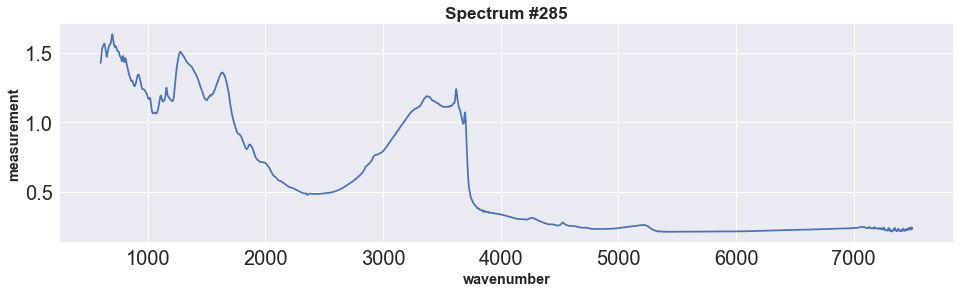

In [5]:
spectrum_as_series = random_spectrum.iloc[0]
wavenumbers = X.columns
spectrum_array = spectrum_as_series.as_matrix()
numericID = spectrum_as_series.name

plt.figure(figsize=(16,4))
plt.plot(wavenumbers,spectrum_array); plt.title('Spectrum #'+str(numericID), 
                                    fontweight='bold',fontsize='xx-large');
plt.xlabel('wavenumber',fontweight='bold',fontsize='x-large');
plt.ylabel('measurement',fontweight='bold',fontsize='x-large');

For some more basic visualizations of the data, check out our
[data visualization notebook](notebooks/00_A - Exploring and Visualizing Data.ipynb).

It's important to dive deep and design specific data visualization tools
for the problem at hand -- every dataset is different!
To see some more advanced interactive visualizations,
check out our
[interactive visualization notebook](notebooks/00_B - Interactive Data Visualisations.ipynb).

Some insight can also be gained into datasets by examining related information.
For example, our soil samples come from different regions,
which have distinct patterns of rainfall, exposures to wind patterns, etc.
In a business context, these can help you determine the failure patterns of your model.
In a science context, these related pieces of information can help you
transfer insight into new domains or predict new phenomena.
For an example of how to visualize and manipulate geographic data,
which is particularly important for this dataset,
check out our
[geographic data visualization notebook](notebooks/00_C - Visualizing Geo Data.ipynb)

## Data Pre-Processing

Absorption was measured at over 3,000 wavelengths,
resuling in very rich data vectors.
This richness comes at a price.

Though we have 3,000 dimensional inputs,
we have only 1,000 data vectors.
For some models, like
[linear regression](link)
this will lead to
*over-fitting* -
a model that predicts
soil properties for previously-seen samples
extremely well,
but fails to predict soil properties accurately
for samples it has never seen before.

For tree-based models, like
[gradient-boosted trees](./notebooks/05_A - Gradient Boosted Regression Trees - Single Target.ipynb),
having many individually uninformative input dimensions
reduces performance.

And for all models, but especially
[support vector methods](./notebooks/06 - Support Vector Regression.ipynb)
and
[neural networks](./notebooks/04_A - Neural Network Regression.ipynb),
more input dimensions
means more time spent training.

We could resolve this by smoothing and down-sampling,
but many of the spectra contain sharp,
precisely-located peaks
that we'd rather not smooth over.

Instead, we use
[Principal Components Analysis](notebooks/02_A - Dimensionality Reduction with PCA.ipynb),
or PCA,
to reduce the size of our data vectors
while trying to retain as much information as possible.

In [6]:
PCA_transform = sklearn.decomposition.PCA(n_components=100)

## Models

#### Linear Regression

Linear regression is the most commonly used regression method, and it's a good place to start here: it's easy to fit, easy to interpret, and works surprisingly well. We'll use it as a baseline for comparing the performance across models.

Because we have many more measurements per data point than data points, linear regression overfits the data it's trained on and doesn't generalize well to data it hasn't seen. We found that reducing the data to fewer dimensions before fitting the linear model improved the performance, but it didn't do as well as some of the other models.

In [7]:
linear_model = sklearn.linear_model.LinearRegression()

#### Neural Network

The resurgence of
[neural networks](notebooks/04_A - Neural Network Regression.ipynb)
is one of the most exciting new developments
in machine learning in the past decade,
finding applications as diverse as
[beating human beings at Go](https://www.blog.google/topics/machine-learning/what-we-learned-in-seoul-with-alphago/),
[creating visual art](https://deepart.io/),
and
[operating autonomous vehicles](https://blogs.nvidia.com/blog/2016/05/06/self-driving-cars-3/).

Neural networks perform best in situations
with large datasets of very rich, structured data vectors
composed of many individually-uninformative dimensions.
However, we were still able to get decent performance
on this smaller dataset by
[carefully tuning hyperparameters](notebooks/04_B - GridSearchCV for Neural Networks.ipynb).

In [8]:
neural_network = sklearn.neural_network.MLPRegressor(activation = 'relu',
                                                     alpha = 0.0001,
                                                     batch_size = 16,
                                                     beta_1 = 0.9,
                                                     beta_2= 0.99,
                                                     early_stopping = False,
                                                     hidden_layer_sizes = 100,
                                                     learning_rate_init = 0.0001,
                                                     max_iter = 10000,
                                                     tol = 1e-16)

#### Gradient-Boosted Trees

[Gradient Boosted Trees](notebooks/05_A - Gradient Boosted Regression Trees - Single Target.ipynb) 
are a tree ensemble method that
combines decision trees with the
optimization principles of gradient
descent.  Trees are built in an iterative
process, with each stage hoping to be a 
correction based on the residuals of the
previous tree.

Grading Boosting Regression Trees can see
performance improvements from finding an
optimal set of model hyperparameters.  Here we used
Randomized Search Cross-Validation to effectively
sweep the hyperparameter space.

Gradient boosting machines are probaly most
known in their use for web search ranking, but 
they are actually a popular choice for a wide
variety of learning problems.  They are robust
to heterogeneous features and can detect
complex feature interactions.


In [9]:
num_outputs = y.shape[1]

GBR_models = [sklearn.ensemble.GradientBoostingRegressor(n_estimators=5000,
                                                    max_depth=3,
                                                    min_samples_split=10,
                                                    min_samples_leaf=3,
                                                    max_features=0.8,
                                                    learning_rate=0.005)
                                              for _ in range(num_outputs)]

#### Support Vector Machine

[Support Vector Machines](notebooks/06 - Support Vector Regression.ipynb)
are a core component of the machine learning toolkit,
but they are primarily used for
classification tasks,
where the output is a label,
rather than regression tasks like this one,
where the outputs are numbers.

Additionally,
like gradient boosted trees,
support vector regression models
can only predict a single output,
rather than multiple outputs.
This meant that we had to train one model
for calcium content,
one for pH,
and so on.

Despite this handicap,
[by tuning hyperparameters](notebooks/06 - Support Vector Regression.ipynb)
we were able to get good performance
from our ensemble of support vector machines.

In [10]:
num_outputs = y.shape[1]

C = 100; epsilon=1e-1; gamma=1e-2;
SVR_models = [sklearn.svm.SVR(kernel='rbf',
                            C=C, epsilon=epsilon, gamma=gamma) for _ in range(num_outputs)]

### Model Comparison

We compare our models by running random-split
[cross-validation](notebooks/01 - Cross Validation Primer.ipynb).
We get out two metrics:
the *training score*,
which tells us how well the model
can predict the soil properties
for spectra it has seen before,
and
the *test score*,
which estimates how well the model
will predict the soil properties
for novel spectra.

In [11]:
models = [linear_model, neural_network, GBR_models, SVR_models]
model_names = ['Linear Model', 'Neural Network',
              'Gradient-Boosted Trees', 'Support Vector Machine']

num_splits = 20

In [12]:
train_scores, test_scores = compare_models(
                            models, model_names, PCA_transform,
                                X, y, num_splits=num_splits)

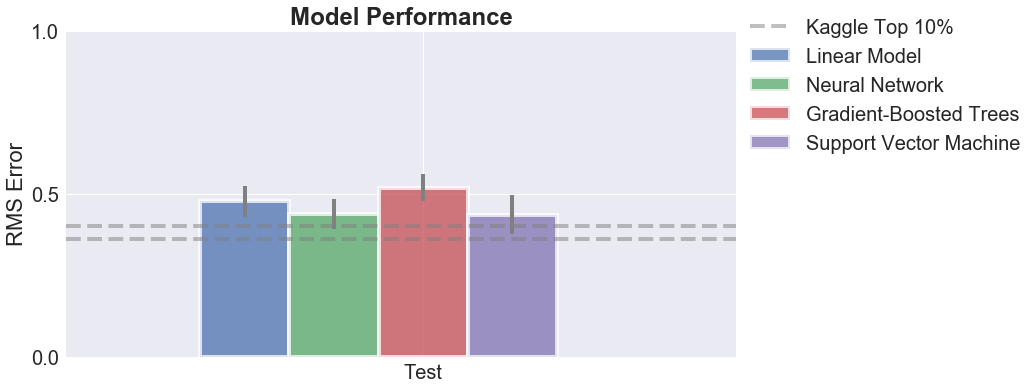

In [13]:
comparison_plot(model_names, train_scores, test_scores)

Error bars are ± standard deviation.

## Conclusions

We were able to achieve performance in the top 10% of Kaggle competitors
with two methods:
neural networks
and
support vector machines.
Considering that the winning methods
used ensembles of up to hundreds of models,
this performance is quite good.

The performance of the linear model
was actually quite good --
a linear model is capable of explaining around 70% of the variance,
occasionally out-performing the more sophisticated models.
Since linear models are far more interpretable than the other models,
it's likely that, in a business setting,
we'd opt for the simple linear model.

We were unable to get good performance from the gradient-boosted trees.
Tree-based models are better known for their good performance on classification tasks
on collections of individually-relevant features,
so perhaps this poor performance is to be expected.
The winning methods on Kaggle
primarily used non-tree methods.